# Pytorch as a generic algebra library:


Pytorch is a generic symbolic math toolbox with all the easiness of a generic matrix software such as numpy or matlab.


## Drawing the Mandelbrot set

#### Installing Requirements:

In [1]:
#!pip install --user torch matplotlib #uncomment to install

#### Lets import all we 'll need:

In [2]:
import torch
from matplotlib import pyplot as plt
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable # just for the ploting colorbars

#### Lets define some ploting code:

While it plots pytorch data, the same code would plot numpy or simple lists.

In [27]:
def plot_field(z):
    real,imaginary = z
    f, ax = plt.subplots(1,2)
    
    im_r=ax[0].imshow(real)
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im_r, cax=cax, orientation='vertical')
    ax[0].set_title("Real")

    im_imag=ax[1].imshow(imaginary)
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im_imag, cax=cax, orientation='vertical')
    ax[1].set_title("Imaginary")

    

def plot_fractal(fractal, color_count=5, figsize=(20,20), cmap="gray"):
    fig = plt.figure(figsize=figsize)
    outside_set = (fractal<fractal.max()).int()
    fractal=(fractal%(color_count-1)+1)*outside_set
    plt.imshow(fractal,cmap=cmap)
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)

#### Lets sample the imaginary plane 

Sampling rate: 600/4
<pre>

Top left corner: <b>-2-2j</b>             Top Right corner:   <b>2-2j</b>


Bottom right:    <b>2+2j</b>             Bottom Right corner: <b>2+2j</b>
</pre>

In [4]:
PIXELS = 600

c_imaginary = torch.linspace(2,-2,PIXELS).view(-1,1).repeat(1,PIXELS)
c_real = torch.linspace(-2,2,PIXELS).view(1,-1).repeat(PIXELS,1)

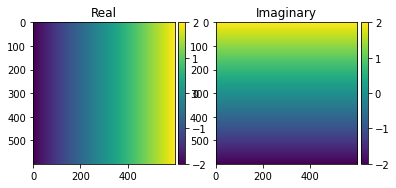

In [5]:
plot_field((c_real,c_imaginary))

#### Defining pytorch complex math

Pytorch doesn't support complex math directly so we model complex tensors as a tuple of tensors.

The first tensor represents real values of the complex tensor and the second tensor in the tuple represents imaginary values.


Addition:
$$ z_1 + z_2 = Re(z_1)+Re(z_2)+i(Im(z_1)+Im(z_2)) $$

Multiplication:
$$ z_1 * z_2 = Re(z_1)*Re(z_2) -Im(z_1) *Im(z_2) + i(Re(z_1)*Im(z_2)-i(Im(z_1)*Re(z_2))) $$

Absolute value (length):
$$ |z| = \sqrt{Re(z)^2+Im(z)^2} $$


In [6]:
complex_add = lambda c1, c2 : (c1[0] + c2[0], c1[1] + c2[1])
complex_mult = lambda c1, c2 : (c1[0] * c1[0] - c2[1] * c2[1], c1[1] * c2[0] + c1[0] * c2[1])
complex_abs = lambda c :(c[0] ** 2 + c[1] ** 2) ** .5

#### Puting all together for modestly heavy CPU computation:

The [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set) is the set of complexnumbers  who do not diverge by applying the recusive formula:
$$ Z = Z^2 + C$$

CPU Computed an image of 600x600 pixels for 128 steps in 205.18 msec.


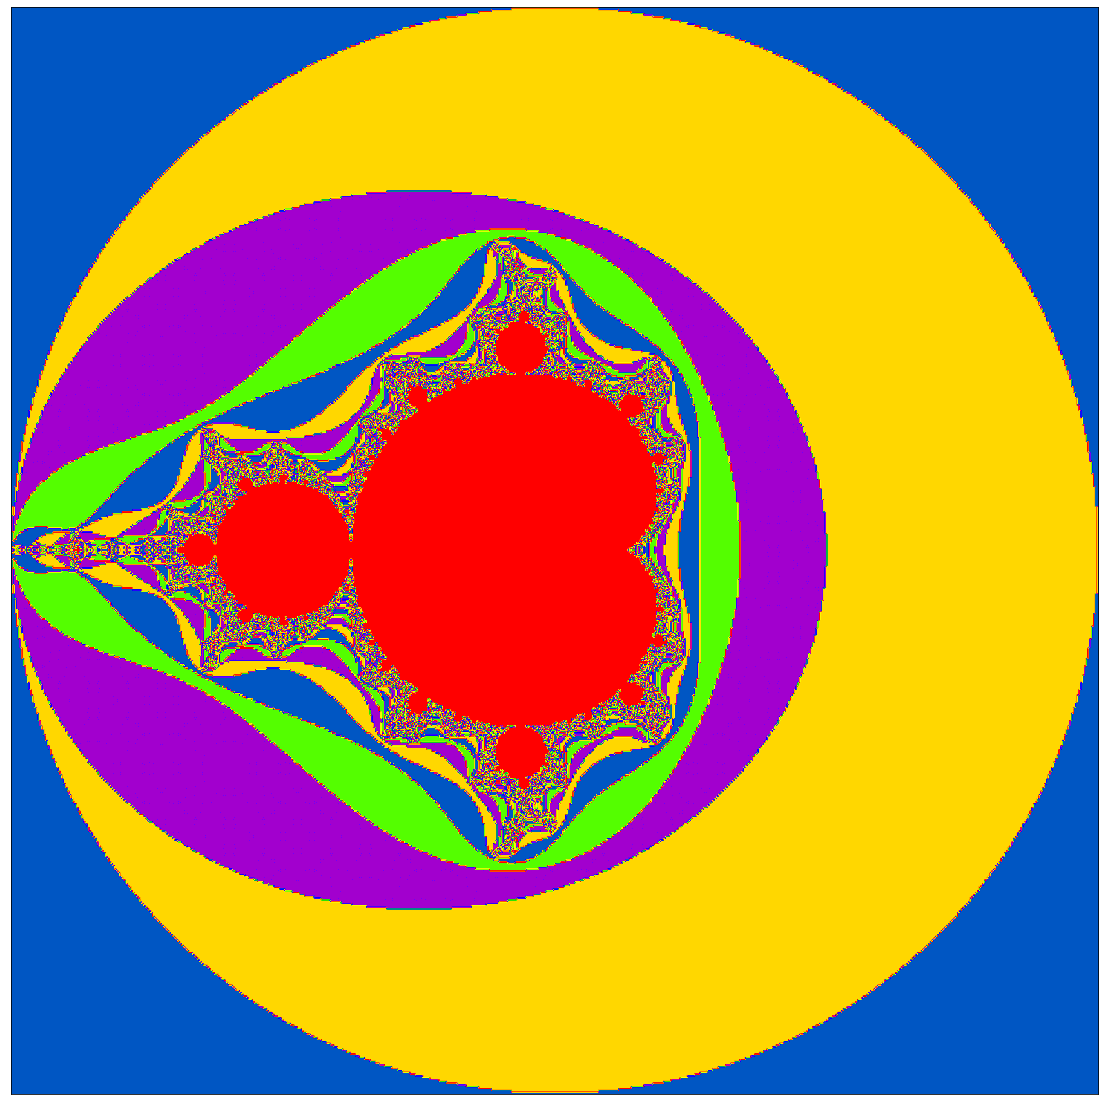

In [26]:
C = c_real, c_imaginary
Z = torch.zeros_like(c_real), torch.zeros_like(c_imaginary)
fractal=torch.zeros([PIXELS,PIXELS],dtype=torch.int32)
t=time.time()
STEPS=128
for n in range(STEPS):
    Z = complex_add(complex_mult(Z, Z), C)
    fractal=fractal+(complex_abs(Z)<2).int()
print("CPU Computed an image of {}x{} pixels for {} steps in {:0.2f} msec.".format(
    PIXELS,PIXELS,STEPS,1000*(time.time()-t)))
plot_fractal(fractal)

#### Runing on GPU rather than CPU:

GPU Computed an image of 600x600 pixels for 128 steps in 55.83 msec.


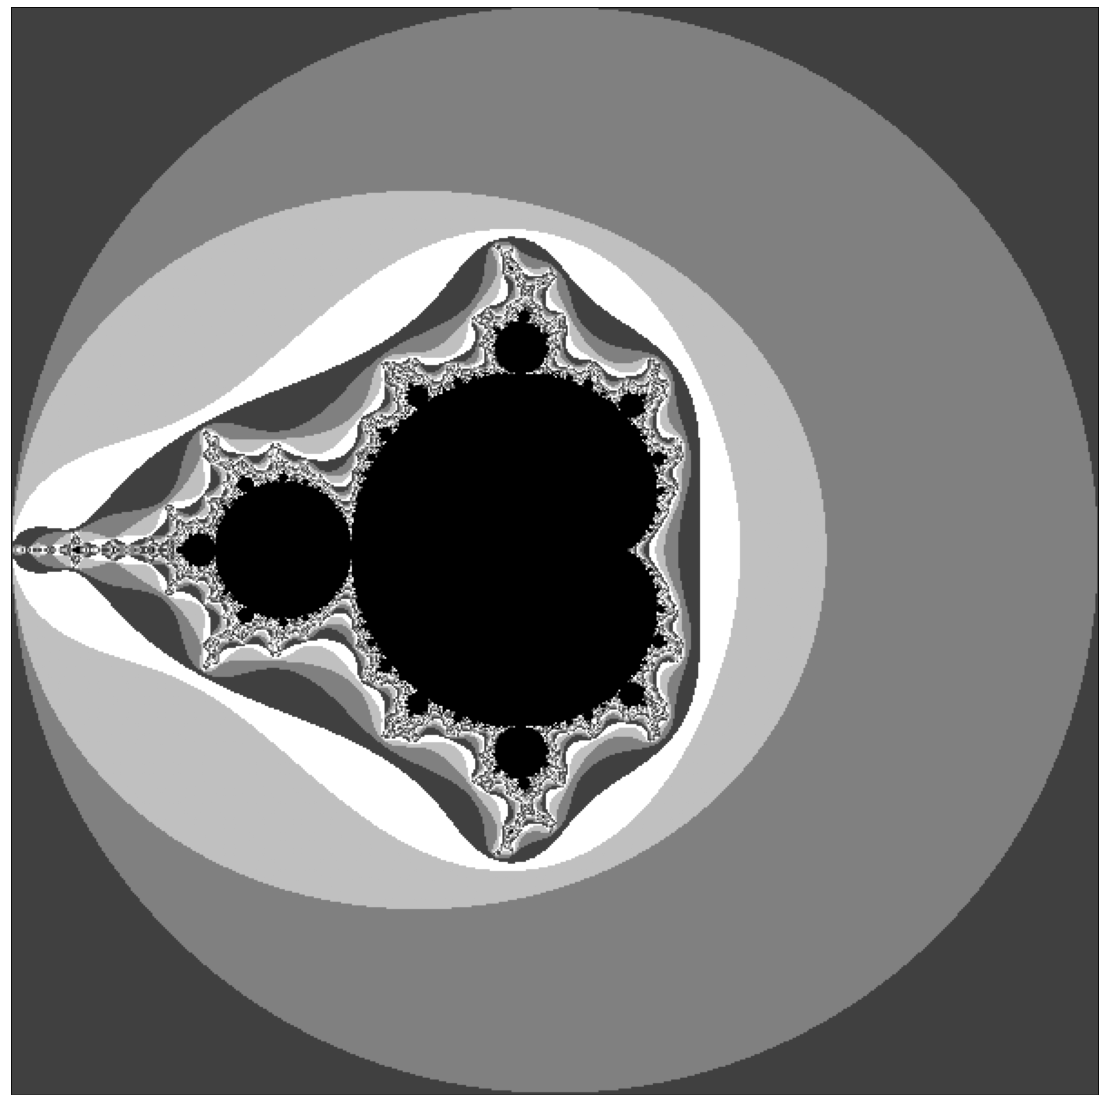

In [12]:
try:
    C = c_real.cuda(), c_imaginary.cuda()
    Z = torch.zeros_like(c_real).cuda(), torch.zeros_like(c_imaginary).cuda()
    t=time.time()
    fractal=torch.zeros([PIXELS,PIXELS],dtype=torch.int32).cuda()
    STEPS=128
    for n in range(STEPS):
        Z = complex_add(complex_mult(Z,Z), C)
        fractal=fractal+(complex_abs(Z)<2).int()
    print("GPU Computed an image of {}x{} pixels for {} steps in {:0.2f} msec.".format(
        PIXELS,PIXELS,STEPS,1000*(time.time()-t)))
    plot_fractal(fractal.cpu())
except:
    print("Could not compute Mandelbrot on the GPU")

### Since version 1.7 pytorch added a new complex tensor type.
### How faster is it to use it?

GPU Computed an image of 600x600 pixels for 128 steps in 17.09 msec.


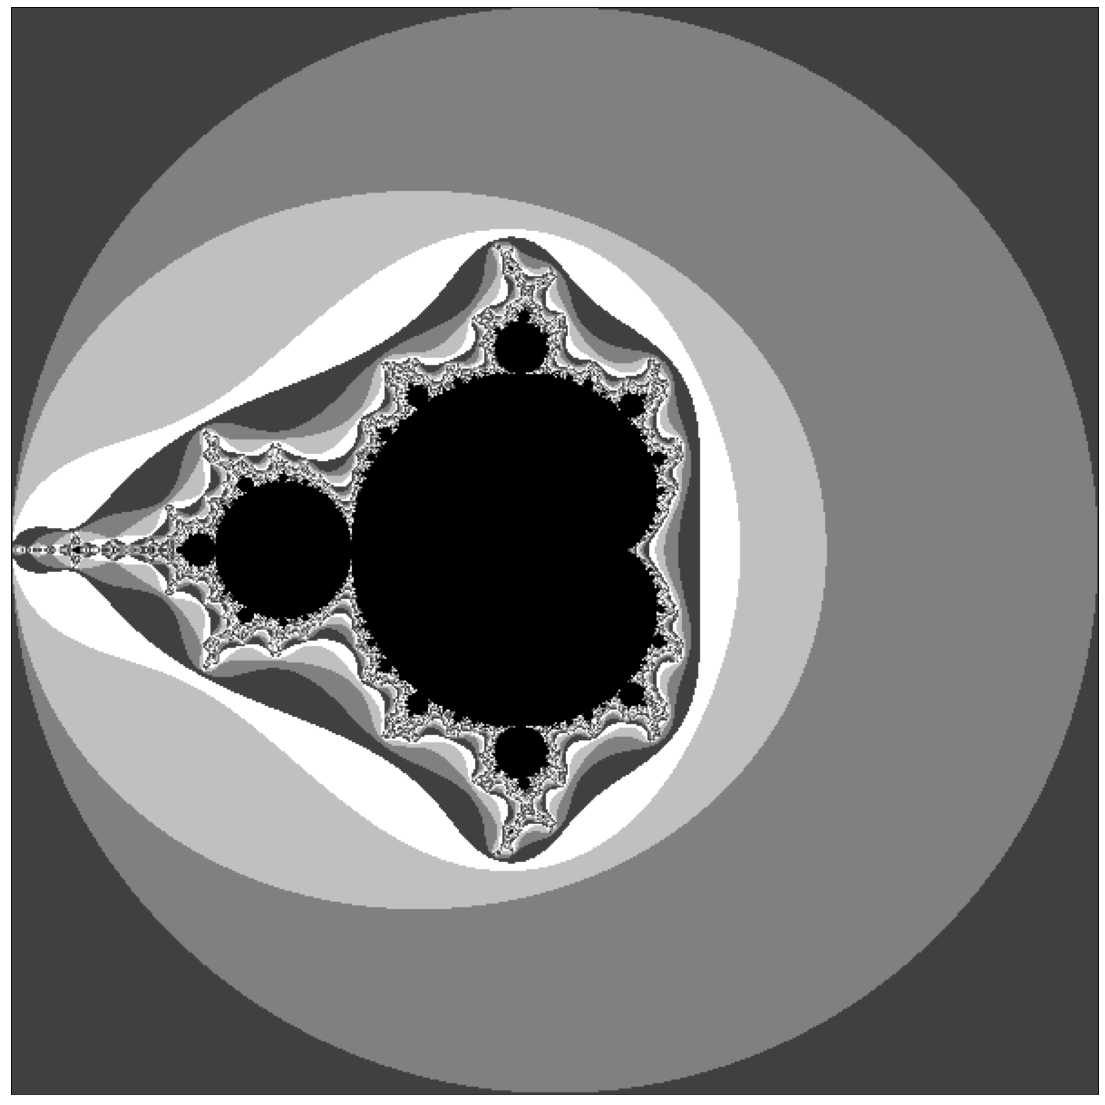

In [22]:
try:
    C=torch.view_as_complex(torch.cat([c_real.unsqueeze(-1), c_imaginary.unsqueeze(-1)],dim=2)).cuda()
    Z = torch.zeros_like(C)
    t=time.time()
    fractal=torch.zeros([PIXELS,PIXELS],dtype=torch.int32).cuda()
    STEPS=128
    for n in range(STEPS):
        Z = Z * Z + C
        fractal=fractal+(Z.abs()<2).int()
    print("GPU Computed an image of {}x{} pixels for {} steps in {:0.2f} msec.".format(
        PIXELS,PIXELS,STEPS,1000*(time.time()-t)))
    plot_fractal(fractal.cpu())
except:
    print("Could not compute Mandelbrot on the GPU, Settled for CPU.")
    C=torch.view_as_complex(torch.cat([c_real.unsqueeze(-1), c_imaginary.unsqueeze(-1)],dim=2)).cpu()
    Z = torch.zeros_like(C)
    t=time.time()
    fractal=torch.zeros([PIXELS,PIXELS],dtype=torch.int32).cpu()
    STEPS=128
    for n in range(STEPS):
        Z = Z * Z + C #complex_add(complex_mult(Z,Z), C)
        fractal=fractal+(Z.abs()<2).int()
    print("GPU Computed an image of {}x{} pixels for {} steps in {:0.2f} msec.".format(
        PIXELS,PIXELS,STEPS,1000*(time.time()-t)))
    plot_fractal(fractal.cpu())

#### TODO on your own

* Change mandelbrot for the range **[-2-0.25j, -1.5+0.25j]**
* Plot the 4th [multibrot](https://en.wikipedia.org/wiki/Multibrot_set) using the formula $$ Z = Z^4 + C $$
* (Longer, at home) Plot PIXELS vs. Duration for CPU and GPU and STEPS vs Duration for CPU and GPU